Data load : 1093 day.
12 vagues détectées.
[2.00e-01 1.13e+02 3.00e+01 2.00e-01 1.71e+02 3.00e+01 2.00e-01 2.14e+02
 3.00e+01 2.00e-01 2.89e+02 3.00e+01 2.00e-01 3.37e+02 3.00e+01 2.00e-01
 3.80e+02 3.00e+01 2.00e-01 4.57e+02 3.00e+01 2.00e-01 5.10e+02 3.00e+01
 2.00e-01 7.25e+02 3.00e+01 2.00e-01 8.89e+02 3.00e+01 2.00e-01 9.54e+02
 3.00e+01 2.00e-01 9.97e+02 3.00e+01]

--- FIN DU CALCUL ---
Message de fin : STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
R^2 = 0.8976
Graphique sauvegardé sous : resultat_covid_final.png


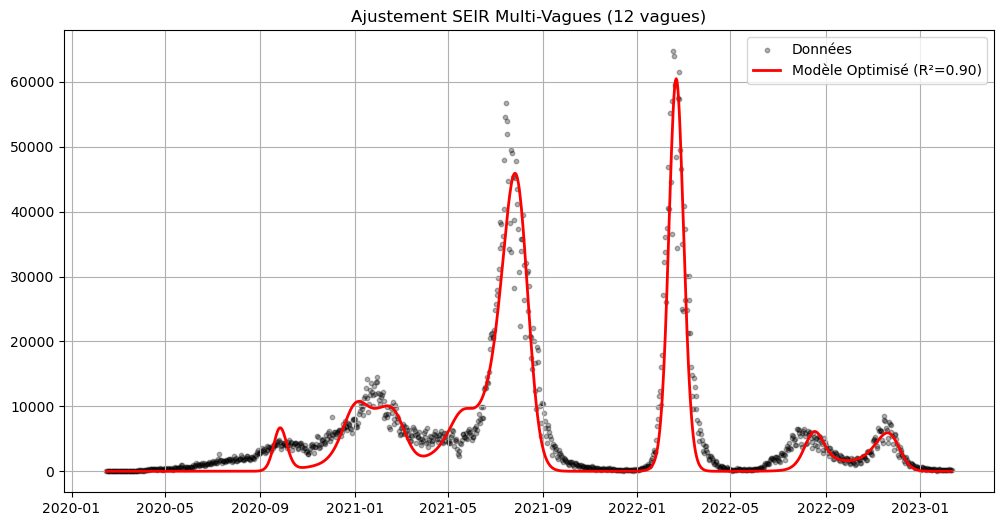

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from scipy.signal import find_peaks




# --- CHARGEMENT ---
filename = 'Feuille de calcul sans titre - Feuille 1 (2).csv'



def parse_french_date(date_str):
    replacements = {'janv.': 'Jan', 'févr.': 'Feb', 'mars': 'Mar', 'avr.': 'Apr', 
                    'mai': 'May', 'juin': 'Jun', 'juil.': 'Jul', 'août': 'Aug', 
                    'sept.': 'Sep', 'oct.': 'Oct', 'nov.': 'Nov', 'déc.': 'Dec'}
    for fr, en in replacements.items():
        if fr in date_str: date_str = date_str.replace(fr, en)
    return pd.to_datetime(date_str, format='%d-%b-%y')


df = pd.read_csv(filename)
df['Date'] = df['Day'].apply(parse_french_date)
df = df.sort_values('Date').reset_index(drop=True)
observed_data = np.maximum(df['Daily new confirmed cases of COVID-19'].values, 0)
days = np.arange(len(observed_data))
print(f"Data load : {len(days)} day.")

# model
N = 273523615
gamma = 0.0696
sigma = 0.6274
dt = 1

def run_seir_simulation(params, n_days):
    S = N - 100
    E = 0
    I = 100
    R = 0
    
    t_vals = np.arange(n_days)
    betas = np.zeros(n_days)
    num_waves = len(params) // 3
    
    # Beta
    for i in range(num_waves):
        r, tm, dm = params[3*i], params[3*i+1], params[3*i+2]
        
        dm = max(dm, 1.0) 
        betas += r * np.exp(-((t_vals - tm)**2) / (dm**2))
    
    predictions = np.zeros(n_days)
    
    # SEIR
    for t in range(n_days):
        beta = betas[t]
        
    
        S = max(0, S)
        I = max(0, I)
        
        new_inf = (beta * S * I / N) * dt
        
        S_next = S - new_inf
        E_next = E + new_inf - sigma * E * dt
        I_next = I + sigma * E * dt - gamma * I * dt
        R_next = R + gamma * I * dt
        
        # Simuled case per day
        predictions[t] = sigma * E * dt 
        
        S, E, I, R = S_next, E_next, I_next, R_next
        
    return predictions



def objective_function(x, observed_data): # function to optimize
    predictions = run_seir_simulation(x, len(observed_data))
    mse = np.mean((observed_data - predictions)**2)
    return mse

# search of peak

smoothed = pd.Series(observed_data).rolling(window=14, center=True).mean().fillna(0).values

peaks, _ = find_peaks(smoothed, height=500, distance=40)  # minimum height peak dectection , same for distance in number of day
print(f"{len(peaks)} vagues détectées.")


#definition of the bound that constrain the different value of r_m , t_m , d_m
x0 = []
bounds = []
for p in peaks:
    #inital random value of r_m , t_m , d_m
    x0.extend([0.2, float(p - 10), 30.0])
    bounds.append((0.01, 5.0))      # r
    bounds.append((0.0, len(days))) # t
    bounds.append((5.0, 300.0))     # d 

x0 = np.array(x0) #value of r_m , t_m , d_m



# #GRG method
x_opt, f_min, info_dict = fmin_l_bfgs_b(
    func=objective_function, # function to optimize
    x0=x0,
    args=(observed_data,),
    bounds=bounds,
    approx_grad=True,
    maxfun=50000,    # Maximum number of function evaluations 
    factr=0.0001,      # precision 
    disp=1
)



#run of the seir with good data
final_preds = run_seir_simulation(x_opt, len(days))

# R2
ss_res = np.sum((observed_data - final_preds)**2)
ss_tot = np.sum((observed_data - np.mean(observed_data))**2)
r2 = 1 - (ss_res / ss_tot)
print(f"R^2 = {r2:.4f}")
#plot
plt.figure(figsize=(12, 6))
plt.scatter(df['Date'], observed_data, color='black', s=10, alpha=0.3, label='Données')
plt.plot(df['Date'], final_preds, color='red', linewidth=2, label=f'Modèle Optimisé (R²={r2:.2f})')
plt.title(f"Ajustement SEIR Multi-Vagues ({len(peaks)} vagues)")
plt.legend()
plt.grid(True)

output_file = 'resultat_covid_final.png'
plt.savefig(output_file)
print(f"Graphique sauvegardé sous : {output_file}")
plt.show()